In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dense, GRU, LSTM
from tensorflow.keras.optimizers import Adam
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit


In [2]:
file_path = ('/content/sample_data/btcpermenit05.csv')
data = pd.read_csv(file_path)
data.head()

,Datetime,Open,High,Low,Close,Adj Close,Volume
0,2021-05-20 00:00:00+01:00,39169.38,39169.38,39169.38,39169.38,39169.38,0
1,2021-05-20 00:01:00+01:00,39196.16,39196.16,39196.16,39196.16,39196.16,0
2,2021-05-20 00:02:00+01:00,39153.21,39153.21,39153.21,39153.21,39153.21,0
3,2021-05-20 00:03:00+01:00,39027.18,39027.18,39027.18,39027.18,39027.18,102473728
4,2021-05-20 00:04:00+01:00,38966.34,38966.34,38966.34,38966.34,38966.34,0


In [3]:
data['Datetime'] = pd.to_datetime(data['Datetime'])
data = data.set_index(data['Datetime'])


In [4]:
data1 = data.drop(['Datetime'], axis=1)
data1.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [5]:
minmax = MinMaxScaler()
data1 = pd.DataFrame(minmax.fit_transform(data1.values),columns=data1.columns, index=data['Datetime'])

In [6]:
data1.head()

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2021-05-20 00:00:00+01:00,0.706861,0.706861,0.706861,0.706861,0.706861,0.000000
2021-05-20 00:01:00+01:00,0.709245,0.709245,0.709245,0.709245,0.709245,0.000000
2021-05-20 00:02:00+01:00,0.705422,0.705422,0.705422,0.705422,0.705422,0.000000
2021-05-20 00:03:00+01:00,0.694205,0.694205,0.694205,0.694205,0.694205,0.027901
2021-05-20 00:04:00+01:00,0.688790,0.688790,0.688790,0.688790,0.688790,0.000000


In [7]:
x = data1['Close']

In [8]:
def split_target(data, look_back=720):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(np.delete(data[i:(i + look_back)], 3, axis=1))
        y.append(data[i + look_back, 3])
    return np.array(X), np.array(y)

In [9]:
cv = TimeSeriesSplit(n_splits=7)

1198 1198


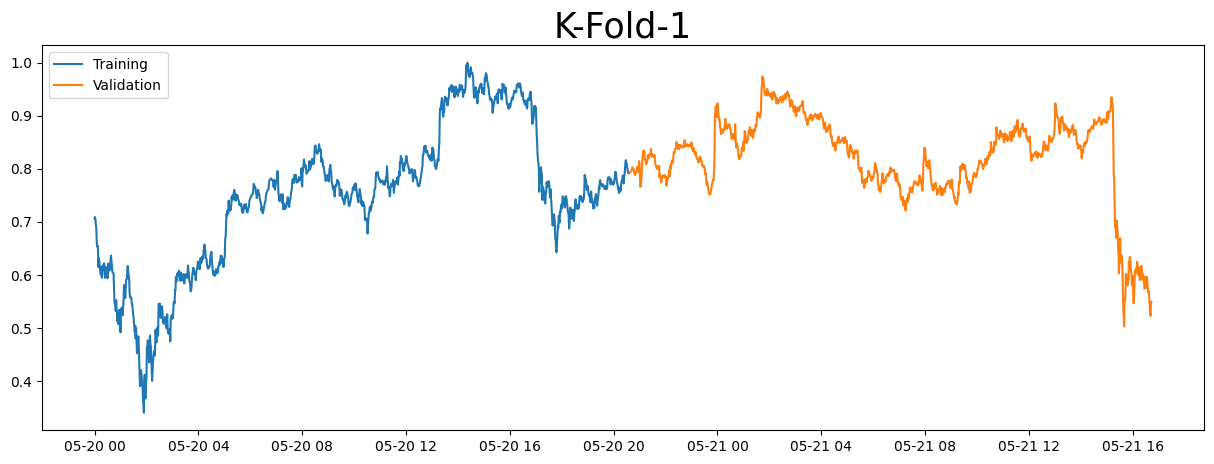

2396 1198


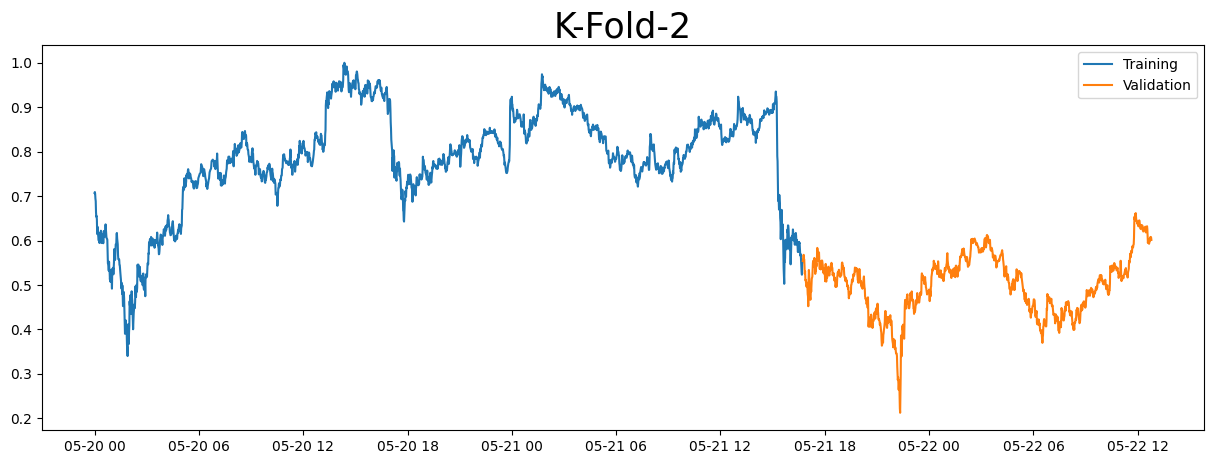

3594 1198


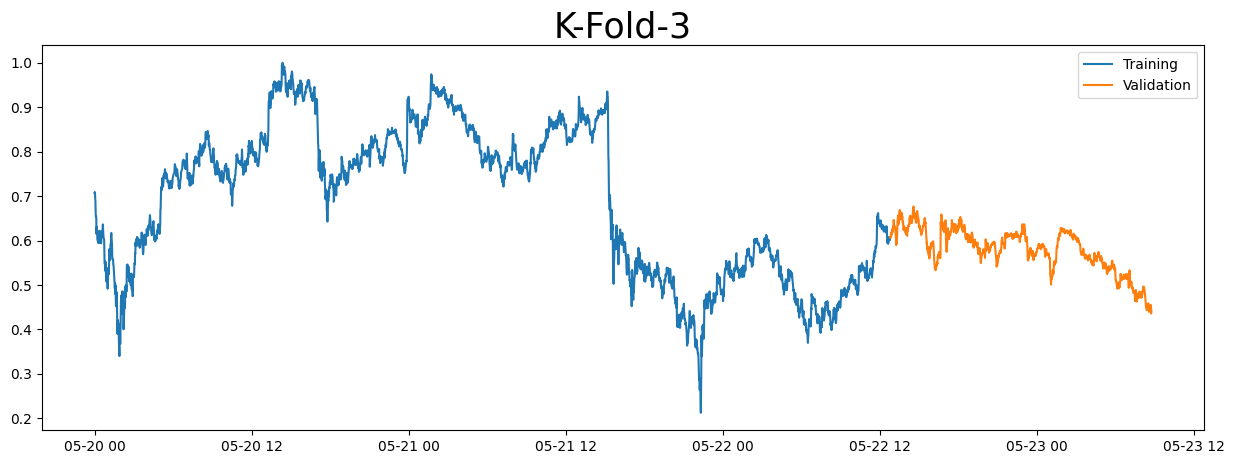

4792 1198


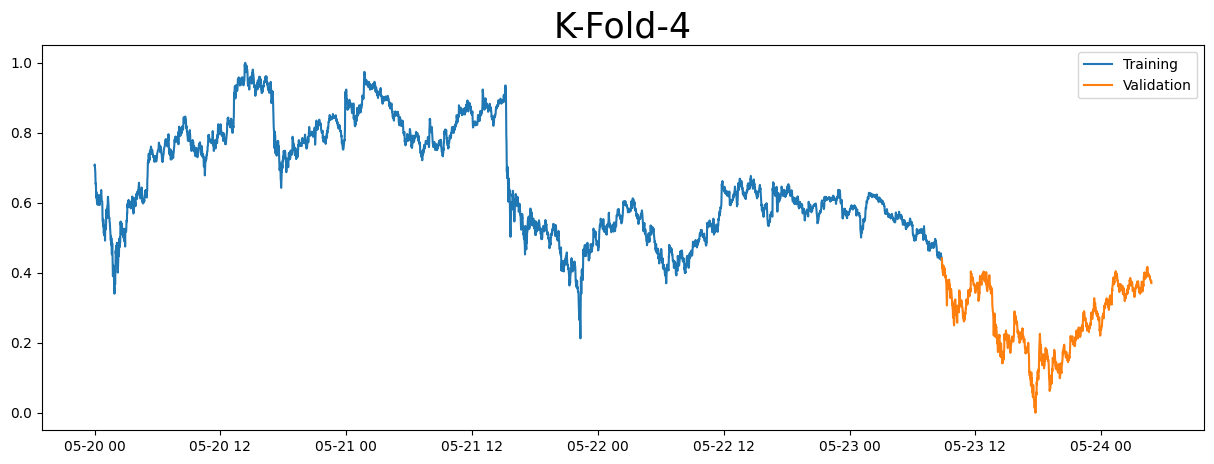

5990 1198


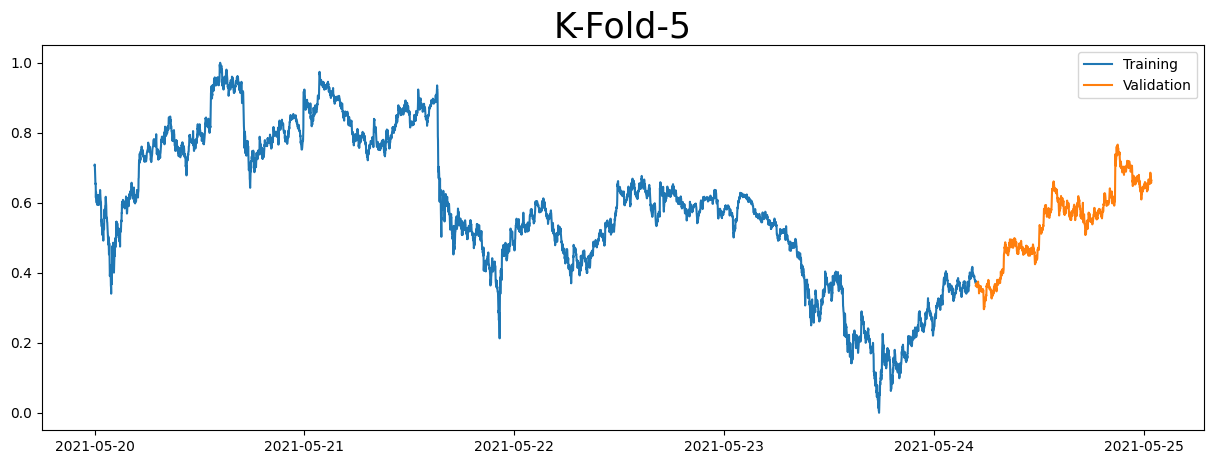

7188 1198


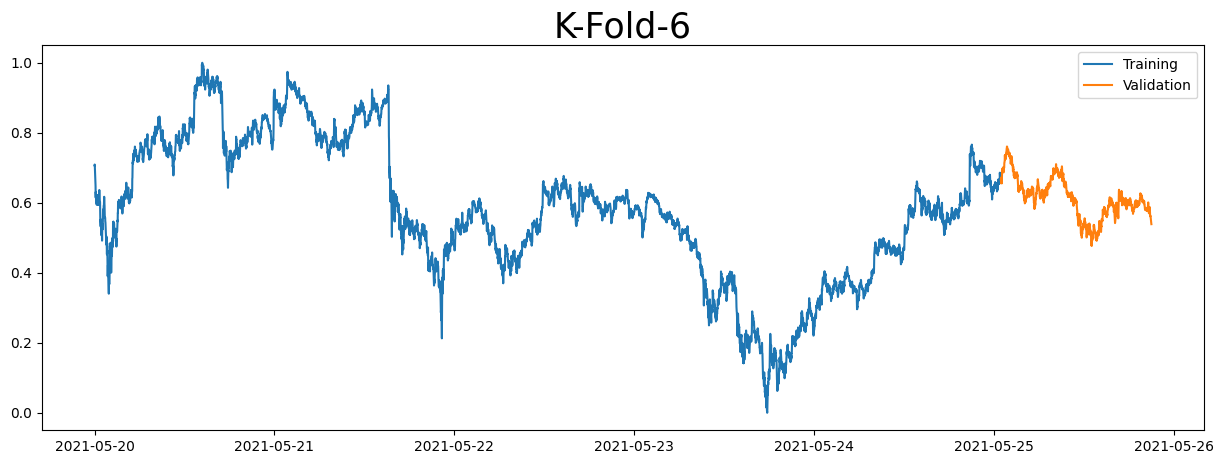

8386 1198


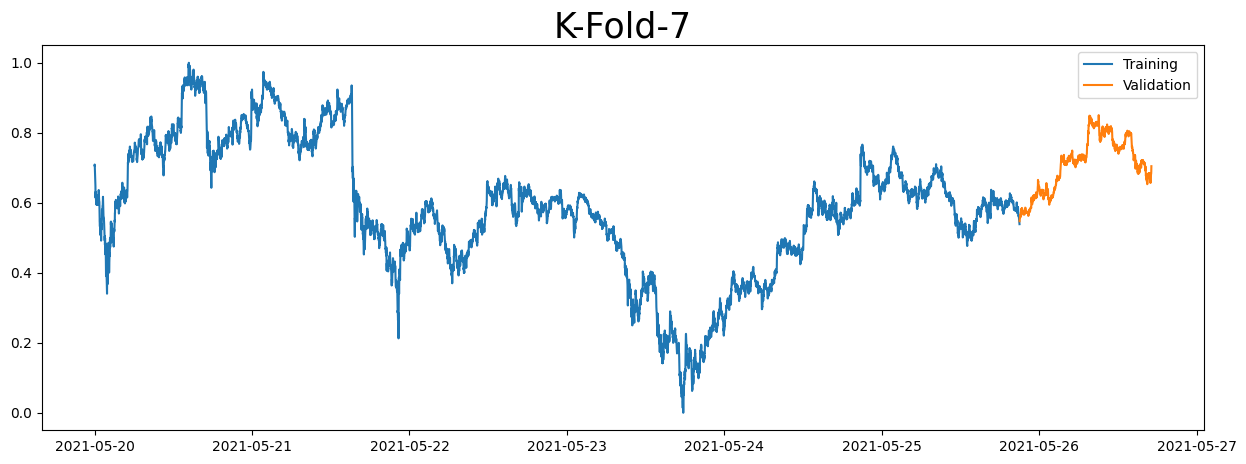

In [10]:
for i, (train_index, valid_index) in enumerate(cv.split(x)):
    train, valid = x[train_index], x[valid_index]

    print(len(train), len(valid))

    plt.figure(figsize=(15,5))
    plt.plot(train)
    plt.plot(valid)
    fold_idx = i+1
    plt.legend(labels=['Training', 'Validation'])
    plt.title('K-Fold-%d' %fold_idx, fontsize=25)
    plt.show()

In [11]:
x = data1.values
print(np.shape(x))

(9584, 6)


In [12]:
look_back = 720

for train_index, valid_index in cv.split(x):
    train, valid = x[train_index], x[valid_index]

    X_train, y_train = split_target(train, look_back)
    X_val, y_val = split_target(valid, look_back)

    print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)


(478, 720, 5) (478, 720, 5) (478,) (478,)
(1676, 720, 5) (478, 720, 5) (1676,) (478,)
(2874, 720, 5) (478, 720, 5) (2874,) (478,)
(4072, 720, 5) (478, 720, 5) (4072,) (478,)
(5270, 720, 5) (478, 720, 5) (5270,) (478,)
(6468, 720, 5) (478, 720, 5) (6468,) (478,)
(7666, 720, 5) (478, 720, 5) (7666,) (478,)


In [13]:
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(720,5)),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size = 2),
    LSTM(64, activation='tanh', return_sequences=False),
    Dense(1)
])

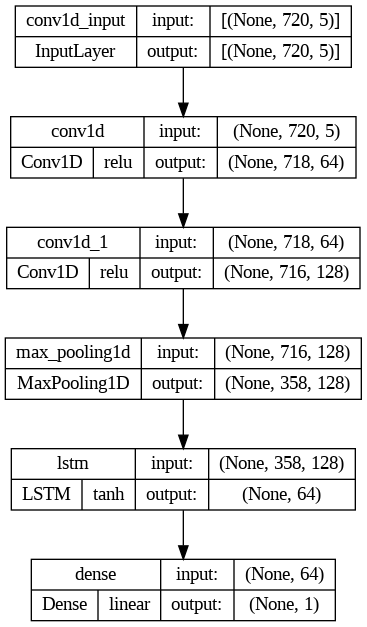

In [14]:
plot_model(model, to_file='model CNN-LSTM CV.png', show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [15]:
mse_scores = []
mae_scores = []
mape_scores = []
rmse_scores = []
r2_scores = []

In [16]:
input_feature = data1.columns
def reverse_scaling(value, scaler, feature_index):
    dummy = np.zeros((len(value), len(input_feature)))
    if len(value.shape) == 1:
        dummy[:, feature_index] = value
    else:
        dummy[:, feature_index] = value[:, 0]

    actual_value = scaler.inverse_transform(dummy)[:, feature_index]
    return actual_value

In [17]:
import datetime
import time

start_time = time.time()
fold_num = 1
fold_times = []

for i, (train_index, valid_index) in enumerate(cv.split(x)):
    print(f'Fold number {fold_num}')
    fold_start_time = time.time()

    # Using train and valid indices directly on x to split into training and validation sets
    X_train, y_train = split_target(x[train_index], look_back=720)  # Ensure this function is defined to handle x correctly
    X_val, y_val = split_target(x[valid_index], look_back=720)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
                  metrics=['mae', 'mse'],
                  loss='huber_loss')

    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    history = model.fit(X_train,
                        y_train,
                        epochs=50,
                        batch_size=128,
                        validation_data=(X_val, y_val),
                        shuffle=False,
                        callbacks=[tensorboard_callback])

    y_pred = model.predict(X_val)

    y_pred_rescaled = reverse_scaling(y_pred, minmax, input_feature.tolist().index('Close'))
    y_val_rescaled = reverse_scaling(y_val, minmax, input_feature.tolist().index('Close'))

    mae = np.mean(np.abs(y_val_rescaled - y_pred_rescaled))
    mae_scores.append(mae)

    mse = np.mean((y_val_rescaled - y_pred_rescaled) ** 2)
    mse_scores.append(mse)

    rmse = sqrt(mse)
    rmse_scores.append(rmse)

    r2 = r2_score(y_val_rescaled, y_pred_rescaled)
    r2_scores.append(r2)

    mape = mean_absolute_percentage_error(y_val_rescaled, y_pred_rescaled)
    mape_scores.append(mape)

    # Save Model 7
    if fold_num == 7:
        model_save_path = f'model_fold_{fold_num}.h5'
        model.save(model_save_path)
        print(f'Model for fold {fold_num} saved to {model_save_path}')

    fold_end_time = time.time()
    fold_time = fold_end_time - fold_start_time
    fold_times.append(fold_time)

    fold_num += 1

end_time = time.time()

Fold number 1
Epoch 1/50
4/4 [==============================] - 6s 532ms/step - loss: 0.2989 - mae: 0.7652 - mse: 0.5979 - val_loss: 0.2118 - val_mae: 0.6452 - val_mse: 0.4236
Epoch 2/50
4/4 [==============================] - 0s 70ms/step - loss: 0.2124 - mae: 0.6442 - mse: 0.4248 - val_loss: 0.1443 - val_mae: 0.5318 - val_mse: 0.2885
Epoch 3/50
4/4 [==============================] - 0s 63ms/step - loss: 0.1419 - mae: 0.5253 - mse: 0.2837 - val_loss: 0.0892 - val_mae: 0.4172 - val_mse: 0.1783
Epoch 4/50
4/4 [==============================] - 0s 60ms/step - loss: 0.0847 - mae: 0.4040 - mse: 0.1693 - val_loss: 0.0469 - val_mae: 0.3010 - val_mse: 0.0938
Epoch 5/50
4/4 [==============================] - 0s 62ms/step - loss: 0.0420 - mae: 0.2815 - mse: 0.0840 - val_loss: 0.0181 - val_mae: 0.1839 - val_mse: 0.0361
Epoch 6/50
4/4 [==============================] - 0s 62ms/step - loss: 0.0144 - mae: 0.1591 - mse: 0.0288 - val_loss: 0.0034 - val_mae: 0.0782 - val_mse: 0.0067
Epoch 7/50
4/4 [===

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:

print(f'Validation MAE Scores for each fold: {mae_scores}')
print(f'Average Validation MAE Score: {np.mean(mae_scores)}')
print('')
print(f'Validation RMSE Scores for each fold: {rmse_scores}')
print(f'Average Validation RMSE Score: {np.mean(rmse_scores)}')
print('')
print(f'Validation R2 Scores for each fold: {r2_scores}')
print(f'Average Validation R2 Score: {np.mean(r2_scores)}')
print('')
print(f'Validation MAPE Scores for each fold: {mape_scores}')
print(f'Average Validation MAPE Score: {np.mean(mape_scores)}')

Validation MAE Scores for each fold: [258.9795749593873, 245.6834060151244, 101.79742797581343, 120.70137470032833, 226.36655222812723, 175.68055303650146, 105.89101655815658]
Average Validation MAE Score: 176.44284363906266

Validation RMSE Scores for each fold: [449.6366895682467, 297.5355765702671, 124.31891649125721, 151.93737693943868, 252.36132333044523, 191.59835833516385, 117.82667714497974]
Average Validation RMSE Score: 226.45927405425692

Validation R2 Scores for each fold: [0.8452926599948088, 0.8439802147383806, 0.9494181098001323, 0.9577573727775728, 0.86740205222032, 0.7393962071587878, 0.9496290980995592]
Average Validation R2 Score: 0.8789822449699374

Validation MAPE Scores for each fold: [0.006575916235236883, 0.006656213468397708, 0.0027248179699169385, 0.0035095519589227213, 0.005902082352771855, 0.004659377303301321, 0.0026636895167994916]
Average Validation MAPE Score: 0.0046702355436209885


In [19]:
total_time = end_time - start_time
print(f'Per Folds execution time: {fold_times} seconds')
print(f'Total execution time: {total_time} seconds')

Per Folds execution time: [17.942234992980957, 22.918757915496826, 31.494144916534424, 40.56195378303528, 49.54237365722656, 58.22453308105469, 67.1176495552063] seconds
Total execution time: 287.8037943840027 seconds
